In [1]:
import os
import sys
import json
import pandas as pd
import numpy as np
import torch
from typing import Literal, TypedDict

In [2]:
sys.path.append("..")
os.environ["USER_PATH"] = "../userdata/"

In [3]:
from system.namespace.store import get_namespace

In [4]:
namespace = get_namespace("test_new")

In [5]:
prefix = "final_test2_"

In [6]:
from system.links.store import get_link_store
from system.msgs.store import get_message_store
from misc.util import now_ts

In [7]:
msgs = get_message_store(namespace)

In [8]:
topics = msgs.get_topics(0, None)
[t.get_text() for t in topics][::-1]

['t/explainlikeimfive', 't/todayilearned', 't/askreddit', 't/askscience']

In [9]:
links = get_link_store(namespace)

In [10]:
total_count = 25000

In [11]:
%%time

roots = [t.get_hash() for t in topics][::-1]
all_ms = []
now = now_ts()
while len(all_ms) < total_count and roots:
    cur_root = roots.pop()
    if len(all_ms) < total_count:
        all_ms.append(cur_root)
    else:
        break
    for link in links.get_all_children(cur_root, now):
        child = link.get_child()
        if child not in all_ms and child not in roots:
            if len(all_ms) < total_count:
                all_ms.append(cur_root)
                roots.append(child)
            else:
                break
# display(roots)
roots = None
len(all_ms)

CPU times: user 23.6 s, sys: 206 ms, total: 23.8 s
Wall time: 24.7 s


25000

In [12]:
len(all_ms)

25000

In [13]:
from system.embedding.store import get_embed_store
from misc.lru import LRU

In [14]:
embeds = get_embed_store(namespace)

In [15]:
role_c = "child"
role_p = "parent"

In [16]:
total_c = embeds.get_embedding_count(role_c)
total_c

488837

In [17]:
total_p = embeds.get_embedding_count(role_p)
total_p

488837

In [18]:
from sklearn.manifold import TSNE

In [19]:
%%time

x_0 = np.vstack([
    embeds.get_embedding(
        msgs,
        role_c,
        mhash,
        no_index=True,
        no_cache=False).ravel().detach().numpy()
    # embed[1].ravel().detach().numpy()
    # for embed in embeds.get_all_embeddings(role_c, progress_bar=True)
    for mhash in all_ms
])
y_0 = x_0.shape[0]
x_1 = np.vstack([
    embeds.get_embedding(
        msgs,
        role_p,
        mhash,
        no_index=True,
        no_cache=False).ravel().detach().numpy()
    # embed[1].ravel().detach().numpy()
    # for embed in embeds.get_all_embeddings(role_p, progress_bar=True)
    for mhash in all_ms
])
y_1 = x_1.shape[0]
y = [
    "tab:blue" for _ in range(y_0)
] + [
    "tab:orange" for _ in range(y_1)
]
x = np.vstack([x_0, x_1])
assert y_0 == y_1
aa_count = y_0
total_c = y_0
total_p = y_1
x.shape, y_0, y_1

CPU times: user 51.2 s, sys: 5.1 s, total: 56.3 s
Wall time: 1min 46s


((50000, 768), 25000, 25000)

In [20]:
x[:5, :]

array([[-0.07917359,  0.02245405,  0.23447645, ...,  0.39907229,
         0.04096369,  0.03679734],
       [-0.07917359,  0.02245405,  0.23447645, ...,  0.39907229,
         0.04096369,  0.03679734],
       [-0.07917359,  0.02245405,  0.23447645, ...,  0.39907229,
         0.04096369,  0.03679734],
       [-0.07917359,  0.02245405,  0.23447645, ...,  0.39907229,
         0.04096369,  0.03679734],
       [-0.07917359,  0.02245405,  0.23447645, ...,  0.39907229,
         0.04096369,  0.03679734]])

In [21]:
aa = x[list(range(aa_count)) + list(range(total_c, total_c + aa_count)), :]
aa_y = [
    "tab:blue" for _ in range(aa_count)
] + [
    "tab:orange" for _ in range(aa_count)
]
aa.shape

(50000, 768)

In [22]:
aa[:5, :]

array([[-0.07917359,  0.02245405,  0.23447645, ...,  0.39907229,
         0.04096369,  0.03679734],
       [-0.07917359,  0.02245405,  0.23447645, ...,  0.39907229,
         0.04096369,  0.03679734],
       [-0.07917359,  0.02245405,  0.23447645, ...,  0.39907229,
         0.04096369,  0.03679734],
       [-0.07917359,  0.02245405,  0.23447645, ...,  0.39907229,
         0.04096369,  0.03679734],
       [-0.07917359,  0.02245405,  0.23447645, ...,  0.39907229,
         0.04096369,  0.03679734]])

In [23]:
aa[aa_count - 1:aa_count + 4,:]

array([[-0.0795752 ,  0.01963777,  0.23050669, ...,  0.40045086,
         0.0353223 ,  0.03739193],
       [-0.06811157,  0.05183464,  0.00393199, ...,  0.40810242,
         0.07356177, -0.00351764],
       [-0.06811157,  0.05183464,  0.00393199, ...,  0.40810242,
         0.07356177, -0.00351764],
       [-0.06811157,  0.05183464,  0.00393199, ...,  0.40810242,
         0.07356177, -0.00351764],
       [-0.06811157,  0.05183464,  0.00393199, ...,  0.40810242,
         0.07356177, -0.00351764]])

In [24]:
x = None
y = None

In [25]:
def angle_color(xs, ys):
    dx = xs[1] - xs[0]
    sq_length = (xs[1] - xs[0])**2 + (ys[1] - ys[0])**2
    if np.isclose(sq_length, 0.0):
        res = 0.0
    else:
        dxnorm = dx / np.sqrt(sq_length)
        res = np.rad2deg(np.arccos(dxnorm))
        if ys[1] > ys[0]:
            res = 360.0 - res
        res /= 360.0
    return hsv_to_rgb([res, 0.8, 0.8])

In [26]:
def sigmoid(x):  
    return np.exp(-np.logaddexp(0, -x))

def distance(a, b):
    # return np.log1p(
    return np.exp(-np.dot(a, b))
    # return 1.0 - sigmoid(np.dot(a, b))

In [27]:
force_recompute = False
outfile = f"{prefix}tsne2.pq"

In [28]:
%%time

if force_recompute or not os.path.exists(outfile):
    aa_embedded = TSNE(
        n_components=2,
        learning_rate="auto",
        init="pca",
        perplexity=50,
        method="barnes_hut",
        random_state=42,
        metric=distance,
        n_jobs=-1).fit_transform(aa)
    df = pd.DataFrame({"x": aa_embedded[:, 0], "y": aa_embedded[:, 1], "l": aa_y})
    df.to_parquet(outfile)
    display(aa_embedded.shape)
    display(df.head())
else:
    df = pd.read_parquet(outfile)
    display(df.head())

,x,y,l
0,28.142153,1.167679,tab:blue
1,28.142153,1.167679,tab:blue
2,28.142153,1.167679,tab:blue
3,28.142153,1.167679,tab:blue
4,28.142153,1.167679,tab:blue


CPU times: user 21.3 ms, sys: 8.58 ms, total: 29.9 ms
Wall time: 33.5 ms


In [29]:
df.iloc[aa_count - 1:, :].head()

,x,y,l
24999,31.939358,6.253235,tab:blue
25000,-22.125263,10.967663,tab:orange
25001,-22.125263,10.967663,tab:orange
25002,-22.125263,10.967663,tab:orange
25003,-22.125263,10.967663,tab:orange


In [30]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.colors import hsv_to_rgb

In [31]:
# tmp_count = 100
# tmp = df.copy().iloc[list(range(tmp_count)) + list(range(total_c, total_c + tmp_count)), :]
# tmp.shape
tmp_count = aa_count
tmp = df.copy()
tmp.shape

(50000, 3)

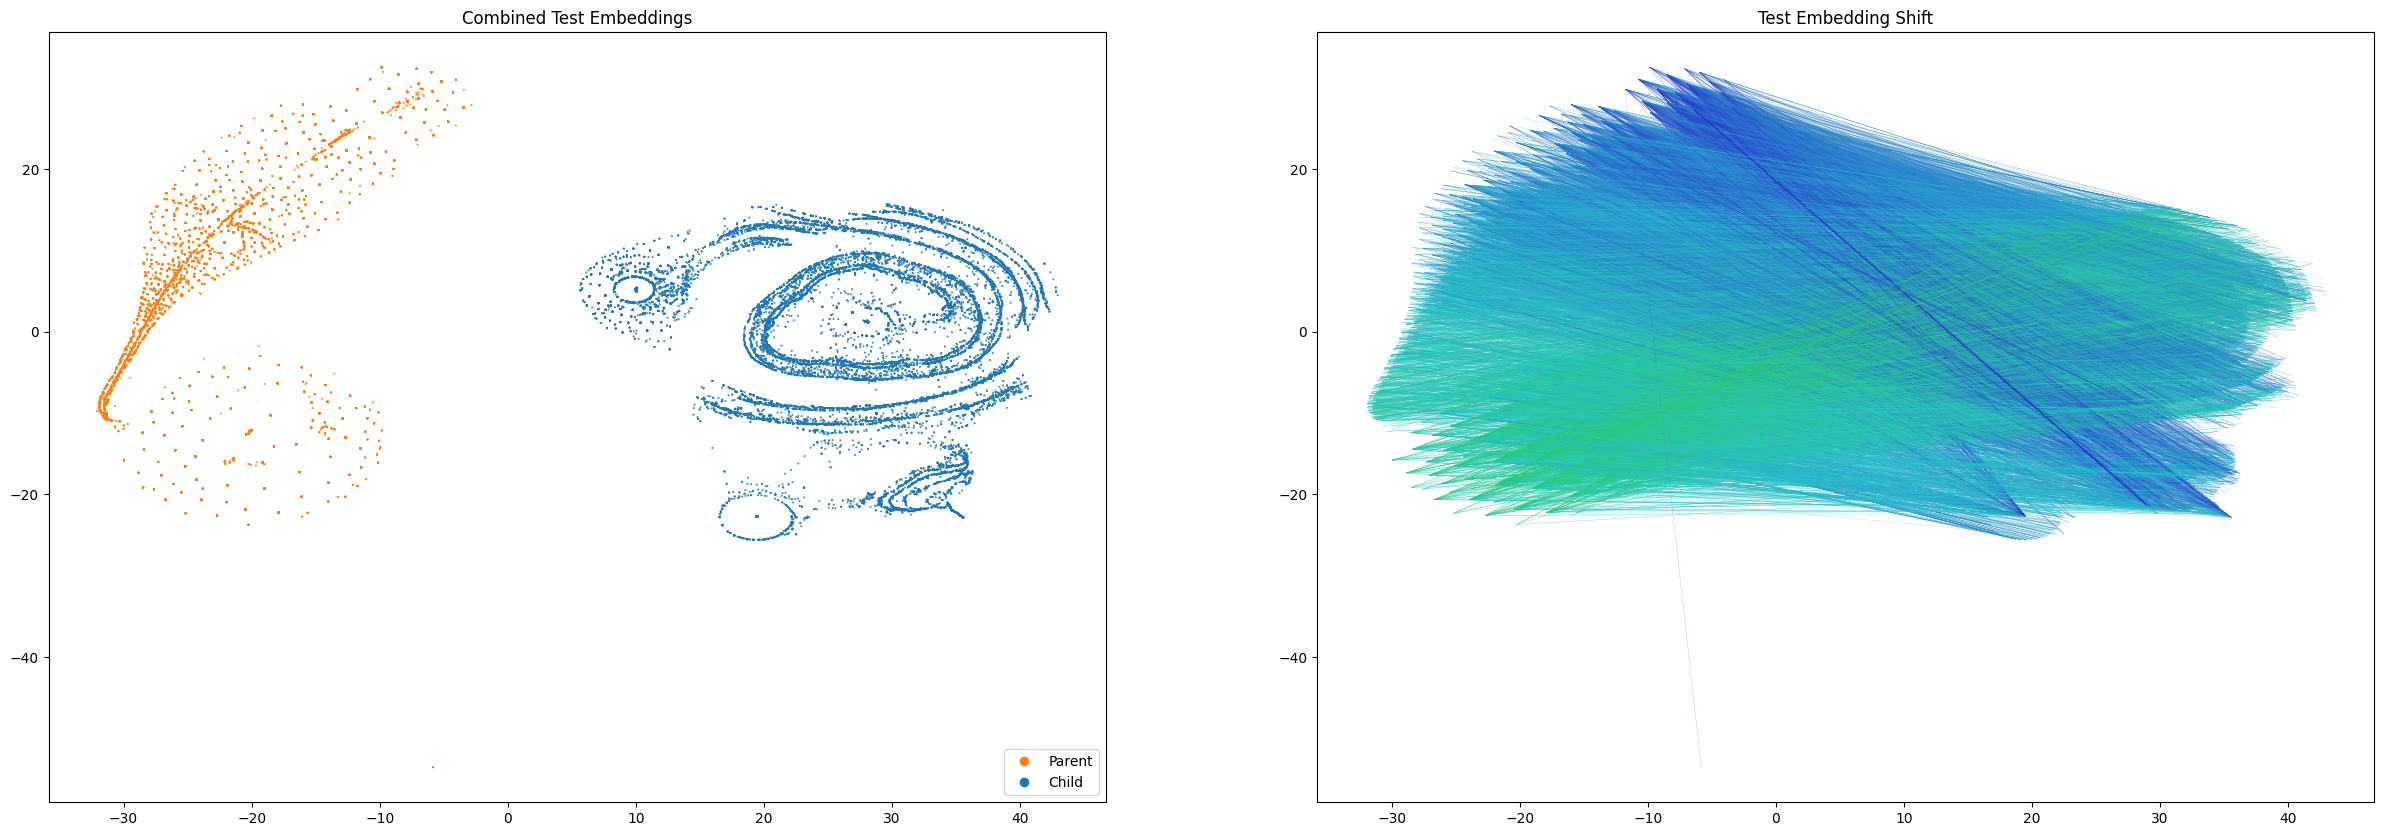

In [33]:
fig, (ax_left, ax_right) = plt.subplots(nrows=1, ncols=2, figsize=(30, 10))
tmp.plot.scatter(
    x="x",
    y="y",
    s=0.2,
    c="l",
    # alpha=0.5,
    xlabel="",
    ylabel="",
    ax=ax_left,
    title="Combined Test Embeddings")
legend_elements = [
    Line2D([0], [0], color="tab:orange", marker="o", lw=0, label="Parent"),
    Line2D([0], [0], color="tab:blue", marker="o", lw=0, label="Child"),
]
ax_left.legend(handles=legend_elements, loc="lower right")
tmp.plot.scatter(
    x="x",
    y="y",
    s=0.2,
    c="l",
    alpha=0.0,
    xlabel="",
    ylabel="",
    ax=ax_right,
    title="Test Embedding Shift")
for ix in range(tmp_count):
    xs = (tmp["x"].iloc[ix], tmp["x"].iloc[ix + tmp_count])
    ys = (tmp["y"].iloc[ix], tmp["y"].iloc[ix + tmp_count])
    ax_right.add_line(Line2D(
        xs,
        ys,
        # alpha=0.5,
        lw=0.1,
        c=angle_color(xs, ys)))
plt.savefig(f"{prefix}full_log1pexpneg.png", bbox_inches="tight")
plt.show()

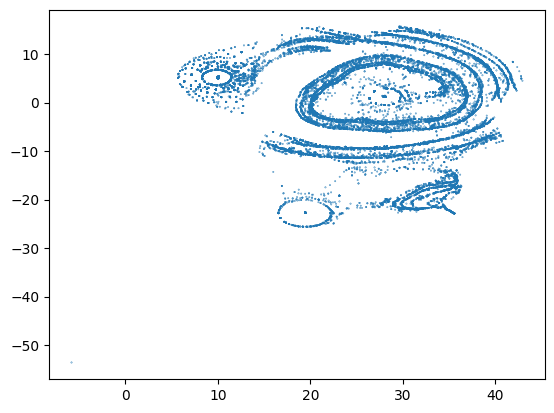

In [66]:
tmp.iloc[:tmp_count, :].plot.scatter(
    x="x",
    y="y",
    s=0.1,
    c="l",
    # alpha=0.5,
    xlabel="",
    ylabel="")
plt.savefig(f"{prefix}child_log1pexpneg.png", bbox_inches="tight")
plt.show()

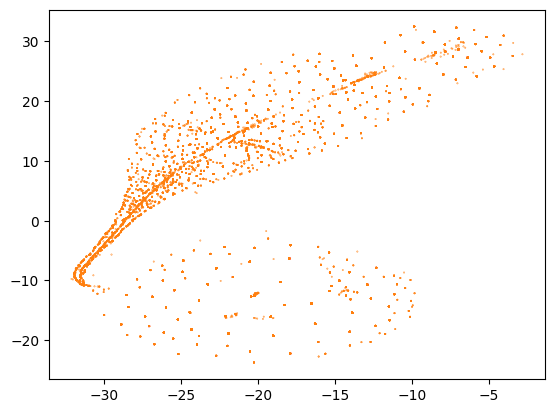

In [67]:
tmp.iloc[tmp_count:, :].plot.scatter(
    x="x",
    y="y",
    s=0.1,
    c="l",
    # alpha=0.5,
    xlabel="",
    ylabel="")
plt.savefig(f"{prefix}parent_log1pexpneg.png", bbox_inches="tight")
plt.show()

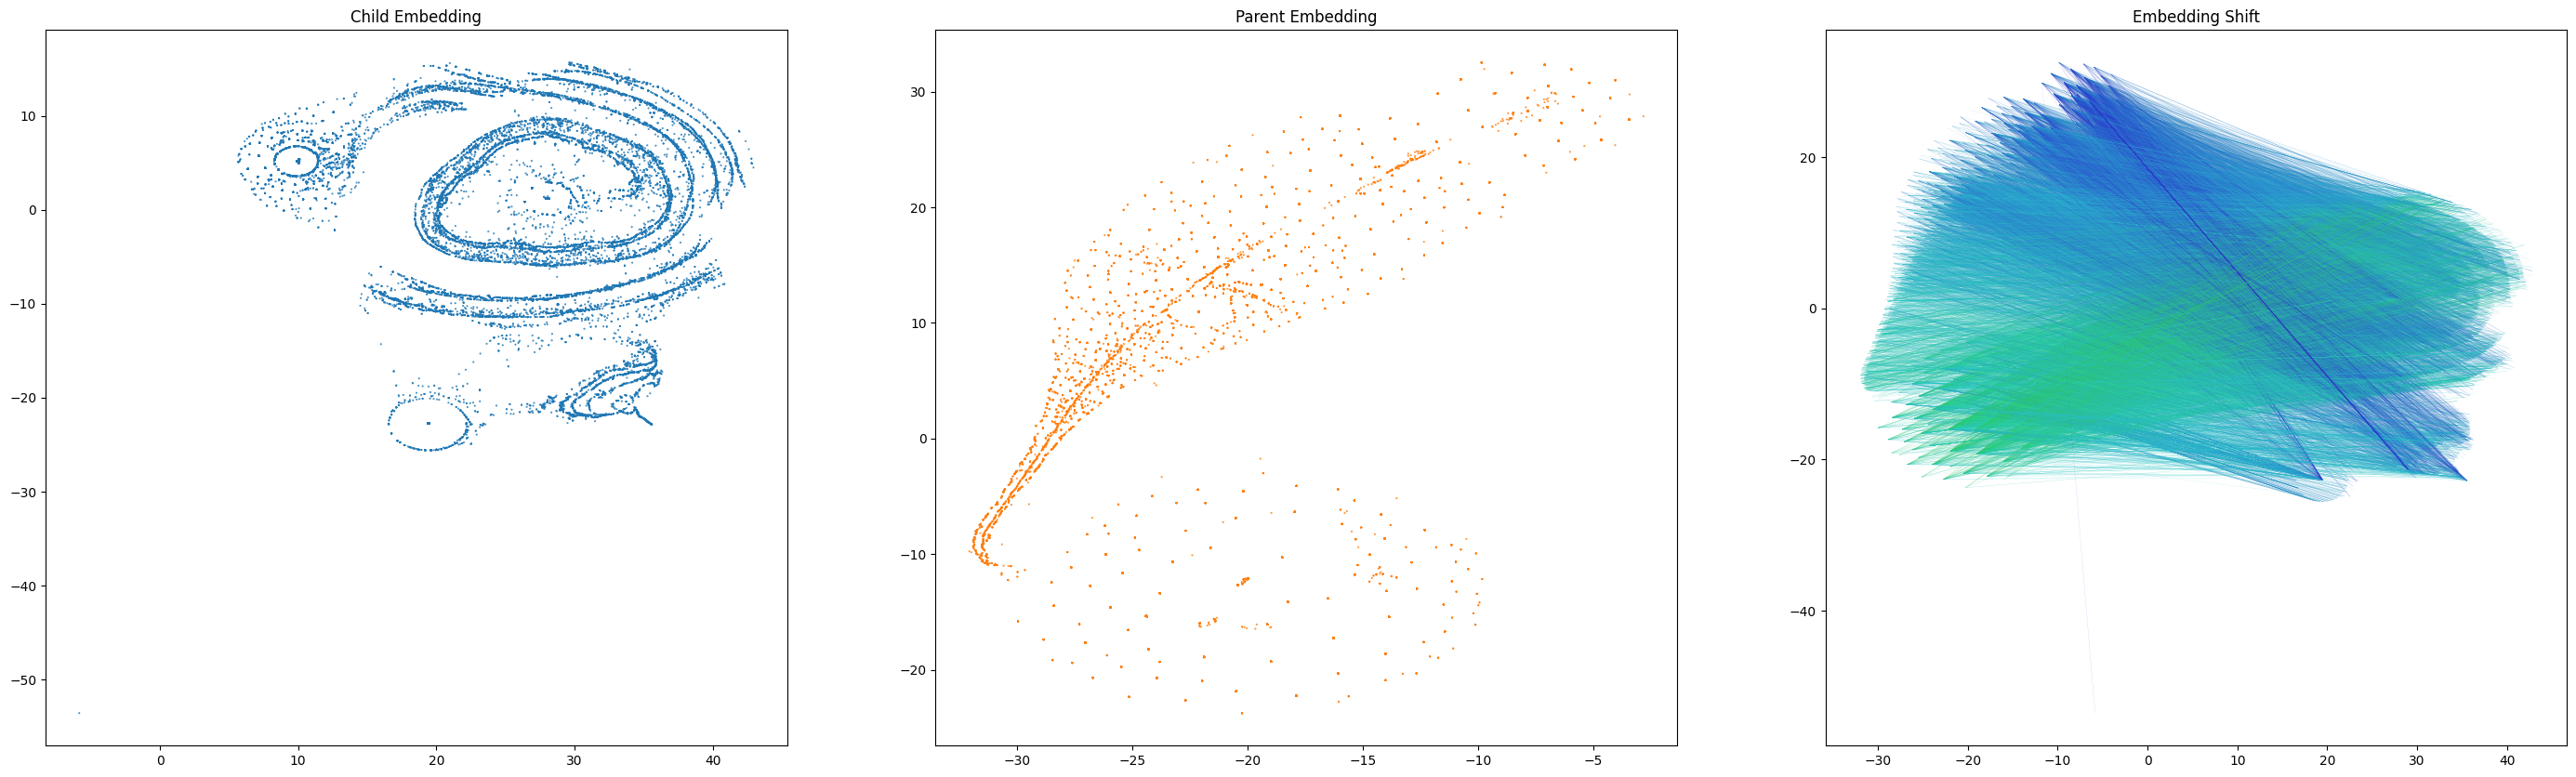

In [68]:
fig, (ax_left, ax_mid, ax_right) = plt.subplots(nrows=1, ncols=3, figsize=(35, 10))
tmp[tmp["l"] == "tab:blue"].plot.scatter(
    x="x",
    y="y",
    s=0.2,
    c="l",
    # alpha=0.5,
    xlabel="",
    ylabel="",
    ax=ax_left,
    title="Child Embedding")
tmp[tmp["l"] == "tab:orange"].plot.scatter(
    x="x",
    y="y",
    s=0.2,
    c="l",
    # alpha=0.5,
    xlabel="",
    ylabel="",
    ax=ax_mid,
    title="Parent Embedding")
tmp.plot.scatter(
    x="x",
    y="y",
    s=0.2,
    c="l",
    alpha=0.0,
    xlabel="",
    ylabel="",
    ax=ax_right,
    title="Embedding Shift")
for ix in range(tmp_count):
    xs = (tmp["x"].iloc[ix], tmp["x"].iloc[ix + tmp_count])
    ys = (tmp["y"].iloc[ix], tmp["y"].iloc[ix + tmp_count])
    ax_right.add_line(Line2D(
        xs,
        ys,
        alpha=0.5,
        lw=0.1,
        c=angle_color(xs, ys)))
plt.savefig(f"{prefix}tri_log1pexpneg.png", bbox_inches="tight")
plt.show()

In [69]:
# k * n log(n) = t
total_time = ((11 * 60.0) + 50 * 60) + 3
k = total_time / (total_c * np.log(total_c))
new_size = 50000
k * new_size * np.log(new_size)

7827.4497114298365

In [70]:
# tt_count = 15000
# tt = x[list(range(tt_count)) + list(range(total_c, total_c + tt_count)), :]
# tt_y = [
#     "tab:blue" for _ in range(tt_count)
# ] + [
#     "tab:orange" for _ in range(tt_count)
# ]
# tt.shape

In [71]:
# %%time

# tt_embedded = TSNE(
#     n_components=2,
#     learning_rate="auto",
#     init="random",
#     perplexity=10,
#     method="barnes_hut",
#     random_state=42,
#     # metric="cosine",
#     n_jobs=-1).fit_transform(tt)

In [72]:
# t_df = pd.DataFrame({"x": tt_embedded[:, 0], "y": tt_embedded[:, 1], "l": tt_y})
# t_df.head()

In [73]:
# fig, (ax_left, ax_right) = plt.subplots(nrows=1, ncols=2, figsize=(30, 10))
# t_df.plot.scatter(
#     x="x",
#     y="y",
#     s=0.2,
#     c="l",
#     # alpha=0.1,
#     xlabel="",
#     ylabel="",
#     ax=ax_left)
# t_df.plot.scatter(
#     x="x",
#     y="y",
#     s=0.2,
#     c="l",
#     alpha=0,
#     xlabel="",
#     ylabel="",
#     ax=ax_right)
# for ix in range(tt_count):
#     xs = (t_df["x"].iloc[ix], t_df["x"].iloc[ix + tt_count])
#     ys = (t_df["y"].iloc[ix], t_df["y"].iloc[ix + tt_count])
#     ax_right.add_line(Line2D(
#         xs,
#         ys,
#         # alpha=0.05,
#         lw=0.1,
#         c=angle_color(xs, ys)))
# plt.savefig("subset_euclid.png", bbox_inches="tight")
# plt.show()

In [74]:
from system.msgs.message import MHash

In [75]:
ref = MHash.parse("377fb320dd0329c906d8f0426b3a652638aa30f12902587392deb9f3e9a9b2ad")
now = now_ts()
[
    (
        msgs.read_message(link.get_parent()).get_hash().to_parseable(),
        msgs.read_message(link.get_parent()).get_text(),
    )
    for link in links.get_all_parents(ref, now)
]

[('13b914f9d74c9bb5bffa3f4b6a594fc7eb0d655f7ccaec3c0b2f067db934077b',
  'I like long romantic walks on the beach, horse rides, and writing haiku. Maybe we should date 🥰')]

In [76]:
# I like long romantic walks on the beach, horse rides, and writing haiku. Maybe we should date 🥰
ref = MHash.parse("13b914f9d74c9bb5bffa3f4b6a594fc7eb0d655f7ccaec3c0b2f067db934077b")
now = now_ts()
[
    (
        msgs.read_message(link.get_child()).get_hash().to_parseable(),
        msgs.read_message(link.get_child()).get_text(),
    )
    for link in links.get_all_children(ref, now)
]

[('377fb320dd0329c906d8f0426b3a652638aa30f12902587392deb9f3e9a9b2ad',
  'The beach? Too much sand.'),
 ('983ce1894820a07ad17f49921d5dbcaa9826f74ba1344ecbba8d8128ed776ea0',
  'Maybe...but I hate the beach. Can we just be lazy on the couch instead? I got a thing for doing nada.')]